In [1]:
# conda install -c conda-forge pdpbox

In [2]:
#pip install eli5

In [3]:
## load required libraries 
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from pdpbox import pdp, get_dataset, info_plots
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from collections import Counter
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import warnings
import eli5
warnings.filterwarnings('ignore')
init_notebook_mode(connected = True)

train_trans = pd.read_csv("Train_trans.csv")

print ("Total Meters: ", train_trans.shape[0], "\nTotal Features: ", train_trans.shape[1])
train_trans.head()

Using TensorFlow backend.


Total Meters:  40500 
Total Features:  52


,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,avg_time_discharging_lag7,...,total_off_time,number_times_restart,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,fail_7
0,5.12,41.11,6.56,25.39,0.086667,-0.006667,4.37,91.70,15.70,39.12,...,49.000000,2.375000,377.080000,367.428750,21.696250,39.005000,4174.875000,14.200000,60.701250,0
1,36.60,5.16,6.23,6.96,0.136667,-1.296667,62.67,6.53,6.16,8.25,...,36.857143,1.000000,350.517857,350.309286,19.883571,32.213571,4161.000000,19.777778,52.097143,0
2,5.51,5.04,4.52,5.96,-0.460000,-0.083333,5.13,5.65,4.14,14.02,...,2.333333,4.095238,346.113333,343.409524,13.675238,20.471429,4152.238095,19.200000,34.146667,0
3,4.66,39.85,35.76,40.69,0.076667,-0.006667,3.93,76.37,60.86,73.53,...,10.789474,0.736842,356.184211,349.844737,16.306842,26.189474,4164.631579,23.625000,42.496316,0
4,5.10,43.24,4.63,5.26,0.040000,-0.153333,4.69,71.44,3.80,6.29,...,14.266667,1.133333,370.904000,367.730000,18.797333,30.812000,4169.800000,12.666667,49.609333,0


In [4]:
X_train = train_trans.drop(['fail_7'], axis = 1)
Y_train = train_trans['fail_7']

In [5]:
gbdt = GradientBoostingClassifier(random_state = 0).fit(X_train, Y_train)

In [6]:
feature_importances = pd.DataFrame(gbdt.feature_importances_, index = X_train.columns, columns = ['importance'])
feature_importances = feature_importances.sort_values('importance', ascending = False)

colors = ["gray"] * 6 + ["green"] * 4
trace1 = go.Bar(y = [x.title() + "  " for x in feature_importances.index[:10][::-1]], 
                x = feature_importances.importance[:10][::-1], 
                name = "feature importance (relative)",
                marker = dict(color = colors, opacity = 0.4), orientation = "h")

data = [trace1]

layout = go.Layout(
    margin = dict(l = 400), width = 900,
    xaxis = dict(range = (0.0, 0.4)),
    title = 'Relative Feature Importance',
    barmode = 'group',
    bargap = 0.25
)
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [7]:
df_test = pd.read_csv("Data Challenage/test.csv")

In [8]:
groupb=['avg_time_charging_lag7','charging_rate_lag7','avg_time_discharging_lag7','discharging_rate_lag7',
        'avg_time_charging_lag5','avg_time_discharging_lag5','avg_time_charging_lag6','avg_time_discharging_lag6',
        'avg_time_charging_lag8','avg_time_discharging_lag8','avg_time_charging_lag9','avg_time_discharging_lag9',
        'avg_time_charging_lag10','avg_time_discharging_lag10','avg_time_charging_lag11','avg_time_discharging_lag11',
        'avg_time_charging_lag12','avg_time_discharging_lag12','avg_time_charging_lag13','avg_time_discharging_lag13',
        'avg_time_charging_lag14','avg_time_discharging_lag14','discharging_rate_lag8']
df_test[groupb] = df_test[groupb].fillna(value = df_test[groupb].mean())

In [9]:
X_test = df_test.drop(['deviceid','LastRecord','Date Deployed'], axis = 1)

In [10]:
X_test["charge_cycle_time_below_12"] = X_test["charge_cycle_time_below_12"].astype(int)

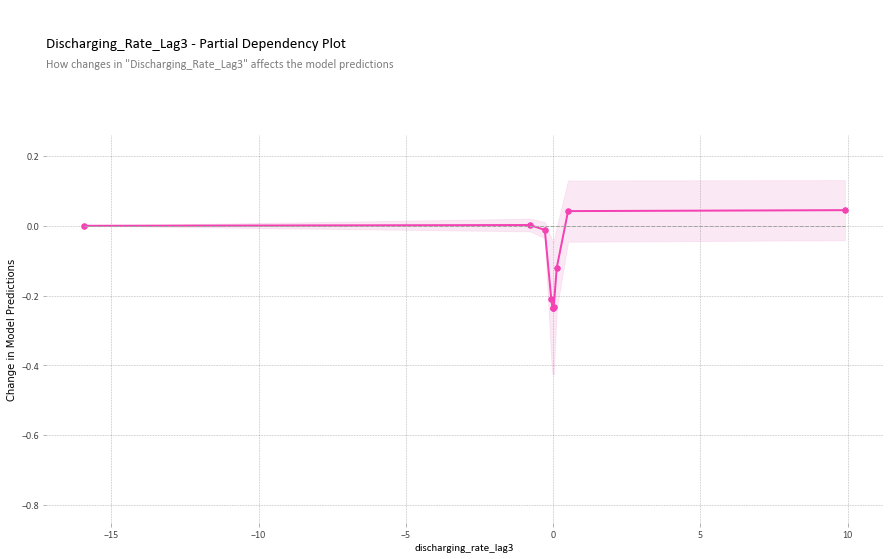

In [11]:
def _plot_pdp(feature, pdp_color, fill_color):
    plot_params = {
        'title': feature.title() + ' - Partial Dependency Plot',
        'title_fontsize': 15,
        'subtitle': 'How changes in "%s" affects the model predictions' % feature.title(),
        'subtitle_fontsize': 12,
        'font_family': 'Calibri',
        'xticks_rotation': 0,
        'line_cmap': 'cool',
        'zero_color': '#a2a5a0',
        'zero_linewidth': 1.0,
        'pdp_linewidth': 2.0,
        'fill_alpha': 0.25,
        'markersize': 5.5,
        'pdp_hl_color': 'green',
        'pdp_color': pdp_color,
        'fill_color': fill_color,

    }
    pdp_goals = pdp.pdp_isolate(model = gbdt, dataset = X_test, model_features = X_test.columns, feature = feature)
    pdp.pdp_plot(pdp_goals, feature, plot_params = plot_params)
    plt.ylabel("Change in Model Predictions");
    plt.show();
    
cols_of_interest = ['discharging_rate_lag3', 'charging_rate_lag3', 'avg_volt_change_charging']

_plot_pdp(cols_of_interest[0], "#f442b3", "#efaad6")

In [12]:
# For all the meters having more than 1 discharging_rate_lag3, 
# the model becomes saturate and shows similar predictions.

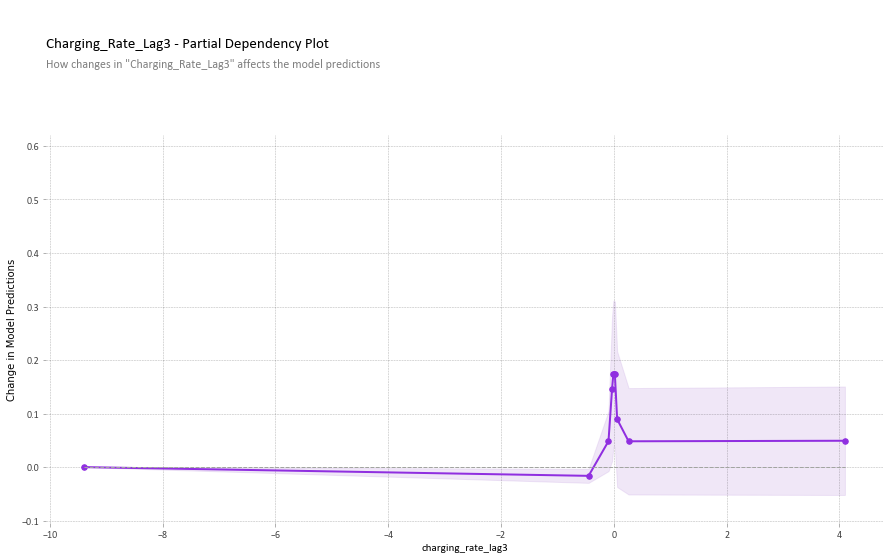

In [13]:
_plot_pdp(cols_of_interest[1], "#902fe0", "#c4a1e0")

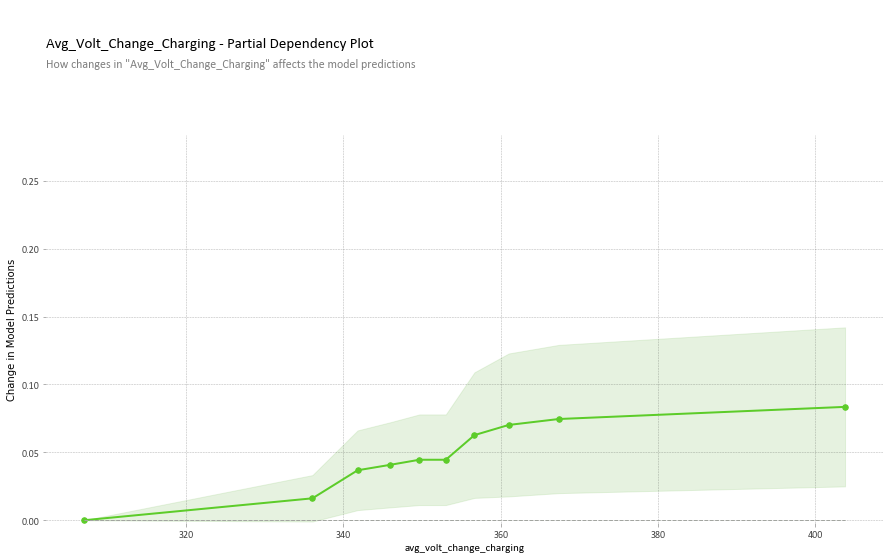

In [14]:
_plot_pdp(cols_of_interest[2], "#5dcc2a", "#9dce86")

In [15]:
# Increasing the avg_volt_change_charging linearly also increases the model performances.

In [16]:
#pip install shap

In [17]:
preds = gbdt.predict(X_test)
dict(Counter(preds))

{1: 545, 0: 3955}

In [18]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(gbdt)

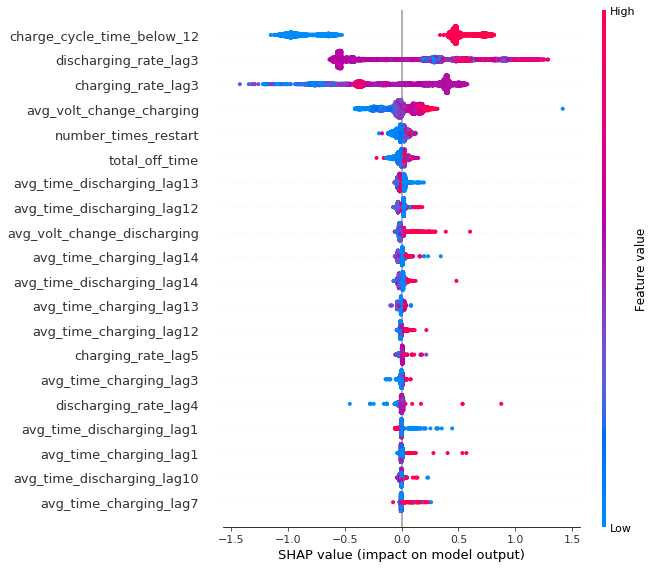

In [19]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [20]:
# Shap values indicate the amount of increase or decrease in model outcome value from the average value of the predictions in the entire dataset.

In [21]:
df_exp = train_trans

In [22]:
import re
pattern1 = ("^avg_time_charging_lag")
match1 = []
names1 = []
for item in df_exp.columns:
    result1 = re.match(pattern1, item)
    match1.append(bool(result1))
    if bool(result1):
        names1.append(item)
names1

['avg_time_charging_lag1',
 'avg_time_charging_lag2',
 'avg_time_charging_lag3',
 'avg_time_charging_lag7',
 'avg_time_charging_lag4',
 'avg_time_charging_lag5',
 'avg_time_charging_lag6',
 'avg_time_charging_lag8',
 'avg_time_charging_lag9',
 'avg_time_charging_lag10',
 'avg_time_charging_lag11',
 'avg_time_charging_lag12',
 'avg_time_charging_lag13',
 'avg_time_charging_lag14']

In [23]:
pattern2 = ("^avg_time_discharging_lag")
match2 = []
names2 = []
for item in df_exp.columns:
    result2 = re.match(pattern2, item)
    match2.append(bool(result2))
    if bool(result2):
        names2.append(item)
names2

['avg_time_discharging_lag1',
 'avg_time_discharging_lag2',
 'avg_time_discharging_lag3',
 'avg_time_discharging_lag7',
 'avg_time_discharging_lag4',
 'avg_time_discharging_lag5',
 'avg_time_discharging_lag6',
 'avg_time_discharging_lag8',
 'avg_time_discharging_lag9',
 'avg_time_discharging_lag10',
 'avg_time_discharging_lag11',
 'avg_time_discharging_lag12',
 'avg_time_discharging_lag13',
 'avg_time_discharging_lag14']

In [24]:
pattern3 = ("^charging_rate")
match3 = []
names3 = []
for item in df_exp.columns:
    result3 = re.match(pattern3, item)
    match3.append(bool(result3))
    if bool(result3):
        names3.append(item)
names3

['charging_rate_lag3',
 'charging_rate_lag7',
 'charging_rate_lag4',
 'charging_rate_lag5',
 'charging_rate_lag6']

In [25]:
pattern4 = ("^discharging_rate")
match4 = []
names4 = []
for item in df_exp.columns:
    result4 = re.match(pattern4, item)
    match4.append(bool(result4))
    if bool(result4):
        names4.append(item)
names4

['discharging_rate_lag3',
 'discharging_rate_lag7',
 'discharging_rate_lag4',
 'discharging_rate_lag5',
 'discharging_rate_lag6',
 'discharging_rate_lag8']

In [26]:
df_exp["avg_time_charging_14"] = 0
for item in names1:
    df_exp["avg_time_charging_14"] = df_exp["avg_time_charging_14"] + df_exp[item]
df_exp["avg_time_charging_14"] = df_exp["avg_time_charging_14"] / len(names1)
df_exp["avg_time_charging_14"]

0        20.321286
1        18.247571
2        14.462143
3        15.245714
4        19.771429
           ...    
40495    13.792857
40496    18.573571
40497    14.123571
40498    14.321429
40499    18.780714
Name: avg_time_charging_14, Length: 40500, dtype: float64

In [27]:
df_exp["avg_time_discharging_14"] = 0
for item in names2:
    df_exp["avg_time_discharging_14"] = df_exp["avg_time_discharging_14"] + df_exp[item]
df_exp["avg_time_discharging_14"] = df_exp["avg_time_discharging_14"] / len(names2)
df_exp["avg_time_discharging_14"]

0        34.634286
1        28.638714
2        21.704286
3        24.710714
4        32.609286
           ...    
40495    22.824286
40496    30.192857
40497    22.622857
40498    23.245000
40499    28.634286
Name: avg_time_discharging_14, Length: 40500, dtype: float64

In [28]:
df_exp["avg_charging_rate"] = 0
for item in names3:
    df_exp["avg_charging_rate"] = df_exp["avg_charging_rate"] + df_exp[item]
df_exp["avg_charging_rate"] = df_exp["avg_charging_rate"] / len(names3)
df_exp["avg_charging_rate"]

0       -0.352000
1       -0.390667
2       -0.116667
3        0.368000
4        0.304667
           ...   
40495   -0.037333
40496   -0.202000
40497    0.347333
40498    0.115333
40499    0.300000
Name: avg_charging_rate, Length: 40500, dtype: float64

In [29]:
df_exp["avg_discharging_rate"] = 0
for item in names4:
    df_exp["avg_discharging_rate"] = df_exp["avg_discharging_rate"] + df_exp[item]
df_exp["avg_discharging_rate"] = df_exp["avg_discharging_rate"] / len(names4)
df_exp["avg_discharging_rate"]

0        0.121111
1       -1.671667
2       -0.258333
3       -0.008889
4       -0.355000
           ...   
40495    0.215556
40496    0.063333
40497   -0.678889
40498    0.011111
40499    0.017222
Name: avg_discharging_rate, Length: 40500, dtype: float64

In [30]:
sorted(list(df_exp.columns))

['avg_charging_rate',
 'avg_discharging_rate',
 'avg_time_charging',
 'avg_time_charging_14',
 'avg_time_charging_lag1',
 'avg_time_charging_lag10',
 'avg_time_charging_lag11',
 'avg_time_charging_lag12',
 'avg_time_charging_lag13',
 'avg_time_charging_lag14',
 'avg_time_charging_lag2',
 'avg_time_charging_lag3',
 'avg_time_charging_lag4',
 'avg_time_charging_lag5',
 'avg_time_charging_lag6',
 'avg_time_charging_lag7',
 'avg_time_charging_lag8',
 'avg_time_charging_lag9',
 'avg_time_discharging',
 'avg_time_discharging_14',
 'avg_time_discharging_lag1',
 'avg_time_discharging_lag10',
 'avg_time_discharging_lag11',
 'avg_time_discharging_lag12',
 'avg_time_discharging_lag13',
 'avg_time_discharging_lag14',
 'avg_time_discharging_lag2',
 'avg_time_discharging_lag3',
 'avg_time_discharging_lag4',
 'avg_time_discharging_lag5',
 'avg_time_discharging_lag6',
 'avg_time_discharging_lag7',
 'avg_time_discharging_lag8',
 'avg_time_discharging_lag9',
 'avg_volt_change_charging',
 'avg_volt_chang

In [31]:
df_plot = df_exp[['avg_charging_rate', 'avg_discharging_rate', 'avg_time_charging', 'avg_time_charging_14',
                  'avg_time_discharging', 'avg_time_discharging_14', 'avg_volt_change_charging',
                  'avg_volt_change_discharging', 'charge_cycle_time_below_12', 'chargecycles', 'cycle_time', 
                  'dischargecycles', 'fail_7', 'max_voltage_day', 'number_times_restart', 'piececount', 
                  'total_off_time']]

In [32]:
import seaborn as sns

In [33]:
#sns.pairplot(df_plot, hue = "fail_7", diag_kind = "hist")

Text(0.5, 1, 'Correlation Matrix Pearson Method')

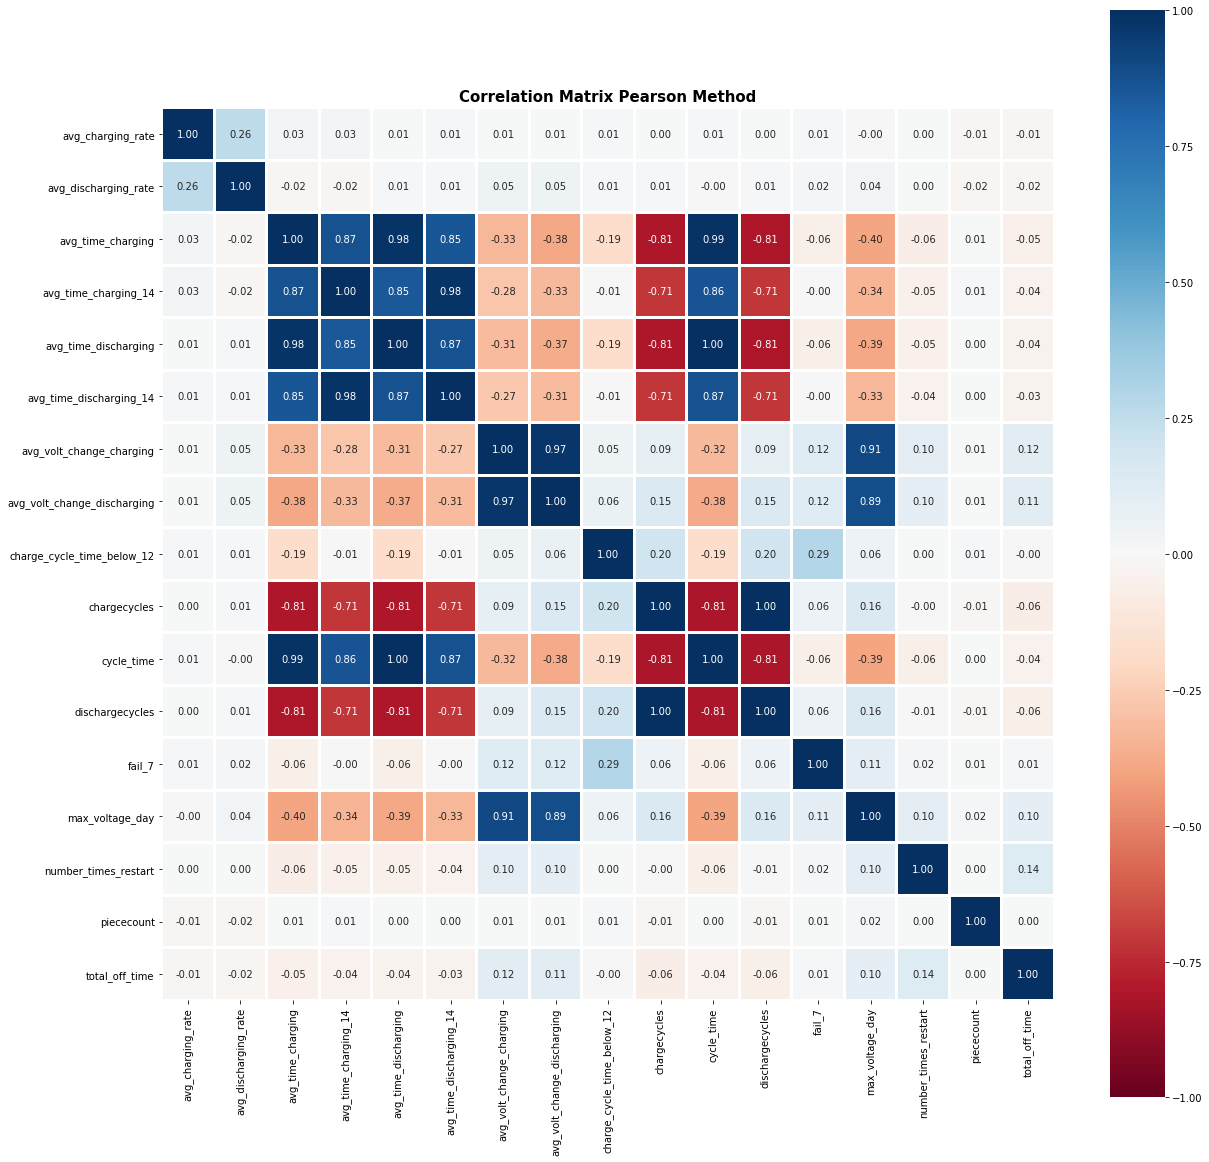

In [34]:
# Pearson Correlation Heatmap
plt.figure(figsize = (20, 20))
sns.heatmap(df_plot.corr(method = 'pearson'), annot = True, fmt = ".2f", cmap = 'RdBu', vmin = -1, vmax = 1, center = 0,
            square = True, linewidths = 2)
plt.title("Correlation Matrix Pearson Method", size = 15, weight = 'bold')

##### Negative
1. chargecycles | cycle_time (-0.81)
2. chargecycles | avg_time_charging (-0.81)
3. chargecycles | avg_time_discharging (-0.81)
4. chargecycles | avg_time_charging_14 (-0.71)
5. chargecycles | avg_time_discharging_14 (-0.71)


6. dischargecycles | cycle_time (-0.81)
7. dischargecycles | avg_time_charging (-0.81)
8. dischargecycles | avg_time_discharging (-0.81)
9. dischargecycles | avg_time_charging_14 (-0.71)
10. dischargecycles | avg_time_discharging_14 (-0.71)

##### Positive
1. cycle_time | avg_time_charging (0.99)
2. cycle_time | avg_time_charging_14 (0.86)
3. cycle_time | avg_time_discharging (1.00)
4. cycle_time | avg_time_discharging_14 (0.87)


5. max_voltage_day | avg_volt_change_charging (0.91)
6. max_voltage_day | avg_volt_change_discharging (0.89)


7. avg_volt_change_charging | avg_volt_change_discharging (0.97)